# Выбор локации для скважины

В имеющихся данных предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. От нас требуется простроить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [10]:
# импортируем необходимые инструменты

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import itertools
from itertools import product
from scipy import stats as st

In [2]:
# загрузим данные

region_0, region_1, region_2 = (pd.read_csv('/datasets/geo_data_0.csv'),
                                pd.read_csv('/datasets/geo_data_1.csv'),
                                pd.read_csv('/datasets/geo_data_2.csv'))

### Первичный анализ данных

In [3]:
# выведем ключевую информацию по каждой таблице

df_list = [region_0, region_1, region_2]
df_list_name = ['Регион 0', 'Регион 1', 'Регион 2']
for df, df_name in zip(df_list, df_list_name):
    print('____________________', df_name, '____________________')
    print()
    print('Выведем первые 5 строк таблицы:')
    display(df.head())
    print()
    print('Посмотрим информацию о типе данных и наличии пропусков:')
    print()
    display(df.info())

____________________ Регион 0 ____________________

Выведем первые 5 строк таблицы:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Посмотрим информацию о типе данных и наличии пропусков:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

____________________ Регион 1 ____________________

Выведем первые 5 строк таблицы:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Посмотрим информацию о типе данных и наличии пропусков:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

____________________ Регион 2 ____________________

Выведем первые 5 строк таблицы:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



Посмотрим информацию о типе данных и наличии пропусков:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Как мы видим, во всех трех датафреймах одинаковый набор столбцов, т.е. одинаковый набор признаков для каждой из скважин в трех разных регионах:

`id` - уникальный идентификатор скважины;

`f0`, `f1`, `f2` - три признака точек (неважно, что они означают, но сами признаки значимы);

`product` - объём запасов в скважине (тыс. баррелей).

В каждой таблице по 100 000 объектов, пропусков нет. Кроме столбца с уникальным номером скважины, все данные числовые (float).

In [4]:
# проверим таблицы на наличие дубликатов
print('Регион 0')
print('Количество дубликатов:', region_0.duplicated().sum())

print('Регион 1')
print('Количество дубликатов:', region_1.duplicated().sum())

print('Регион 2')
print('Количество дубликатов:', region_2.duplicated().sum())

Регион 0
Количество дубликатов: 0
Регион 1
Количество дубликатов: 0
Регион 2
Количество дубликатов: 0


Дубликатов в данных нет.

Далее, выведем информацию о распределении значений всех признаков и их зависимости друг от друга

### Проверим корреляцию между признаками и целью

In [5]:
def describe(df):
    display(df.describe())
    plt.figure(figsize=(6, 6))
    plt.subplot(1, 1, 1)
    plt.title('Корреляция между признаками', size = 12)
    a = sns.heatmap(df.corr('spearman'), annot = True, vmin = -1, vmax = 1, cmap = 'twilight_shifted', square=True, linewidths=0.5)
    
    b = sns.pairplot(df, diag_kind = "hist", diag_kws = {'bins':50})
    plt.suptitle('Диагарммы рассеяния пар признаков и гистограммы', size = 12, y = 1)

_______________________________ Регион 0 _______________________________


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


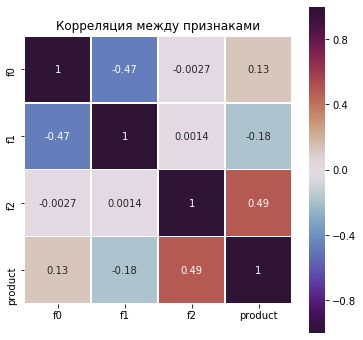

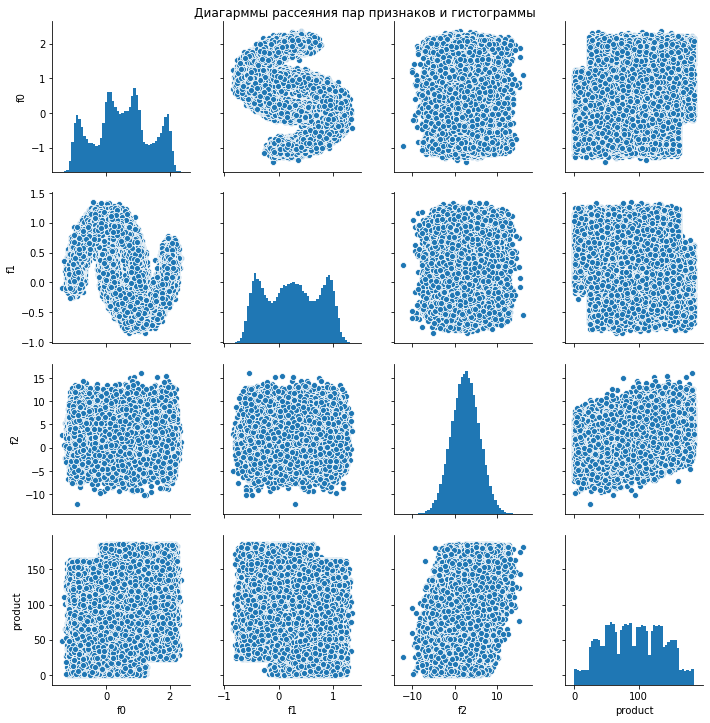

In [6]:
print('_______________________________', 'Регион 0', '_______________________________')
describe(region_0)

Видно, что между признаками сильной корреляции нет, можно заметить умеренную обратную корреляцию между признаками `f0` и `f1`, а также умеренное влияние признака `f2` на целевой показатель. Признаки `f0` и `f1` слабо коррелирую с целевым признаком.

Распределение значений `product` не нормально, имеется несколько выраженных пиков

_______________________________ Регион 1 _______________________________


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


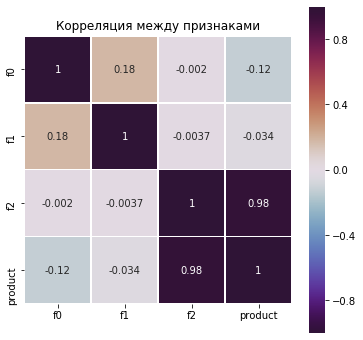

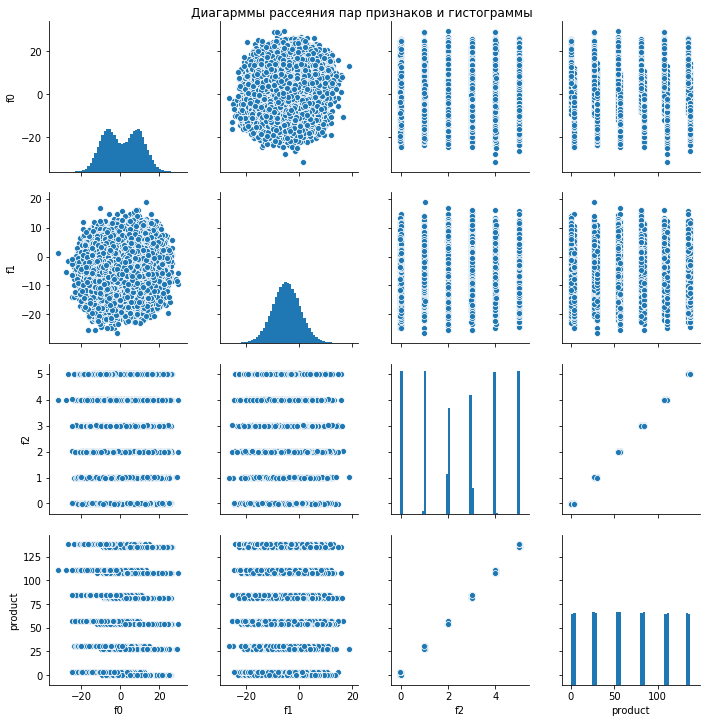

In [7]:
print('_______________________________', 'Регион 1', '_______________________________')
describe(region_1)

Видим очень высокую коррецию между признаком `f2` и целевым признаком, однако мы не можем быть уверены, что в данном случае имеем дело с утечкой данных, т.к. во-первых, не знаем, что именно обозначают значения, во-вторых, в двух остальных выборках такой высокой корреляции нет. Между признаком `f1` и целевым признаком корреляции практически нет, она стремится к нулю. Обычно сложно говорить о пользе таких признаков для обучения модели, однако если удалить признаки с нулевой корреляцией, то у нас останется только один признак, чего может быть недостаточно для качественного обучения модели.

Значения столбца `product`, как и `f2`, четко разделены на 6 парных групп примерно одинакового размера

_______________________________ Регион 2 _______________________________


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


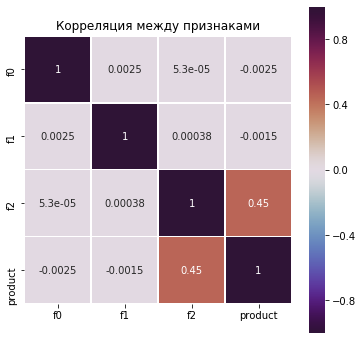

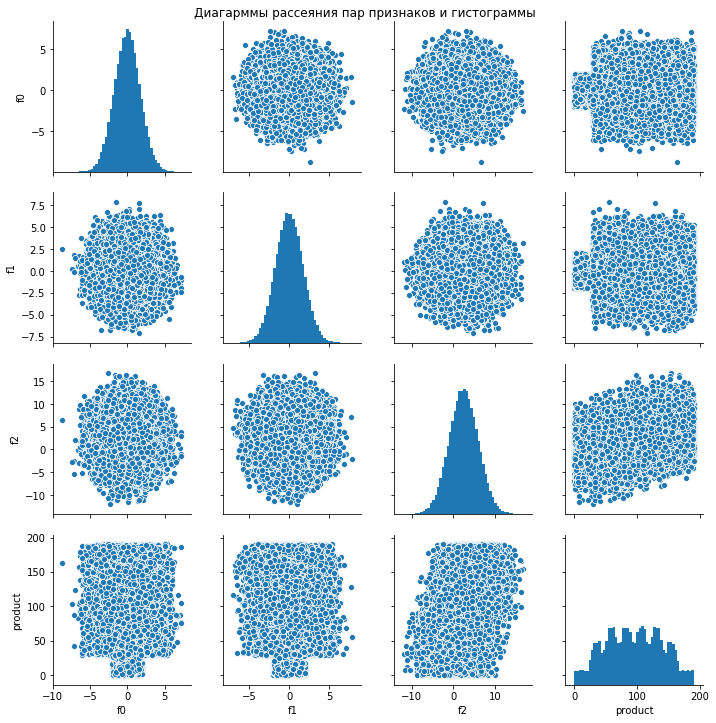

In [8]:
print('_______________________________', 'Регион 2', '_______________________________')
describe(region_2)

Также видим нулевую корреляцию между признаками `f0` и `f1` с целевым признаком и умеренную корреляцию между `f2` и целевым признаком.

Между наборами данных имеются сильные различия.

Регион 1 - самый предсказуемый, но при этом обладает самыми низкими средним и максимальным значениями объема запасов.

### Выбросы в данных

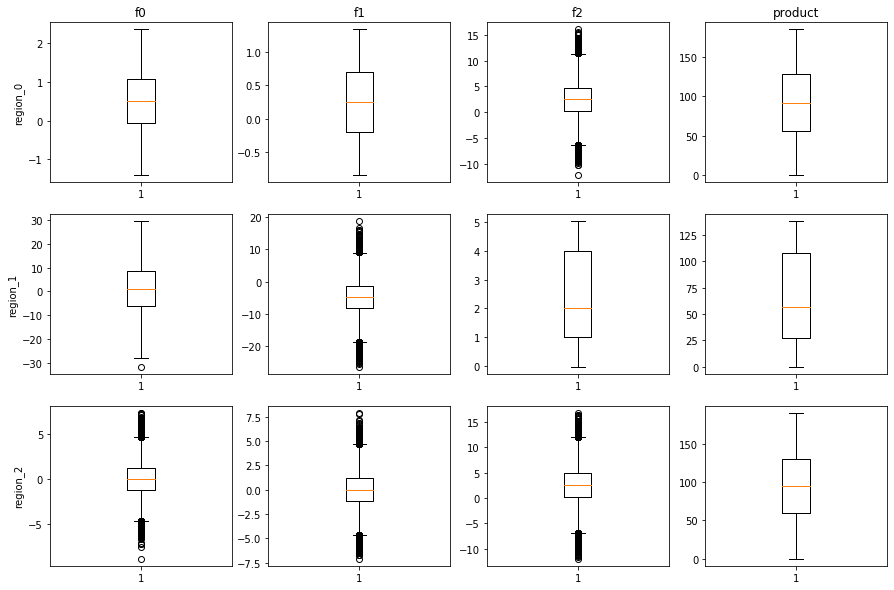

In [11]:
# посмотрим на наличие выбросов, построив график с усами
fig,ax = plt.subplots(3,4,figsize = (15,10))

all_dfs = ["region_0","region_1","region_2"]
num_columns = region_1.columns[1:]
num_columns_with_columns = zip(region_1.columns[1:],range(4))
all_dfs_with_rows = zip([region_0, region_1, region_2],range(3))
# Построим графики
for column in list(itertools.product(all_dfs_with_rows,num_columns_with_columns)):
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]])
# Добавим название фрейма, изображаемого на графике
for row in range(3):
    ax[row][0].set_ylabel(all_dfs[row])
# Добавим название столбца, изображаемого на графике
for column in range(4):
    ax[0][column].set_title(num_columns[column])

По графикам с усами мы видим, что в некоторых столбцах есть выбросы. Выбросы могут негативным образом повлиять на качество обучения модели, поэтому от выбросов следует избавиться.

Избавиться нам предстоит от выбросов в следующих столбцах:

| DataFrame |Column with Outliers|
|:---------:|:------------------:|
|Region_Zero|         f2         |
|Region_One |         f1         |
|Region_Two |     f0, f1, f2     |

### Предобработка данных. Удаляем выбросы

In [12]:
def remove_outliers(df,column):
    q25 = np.array(df[column].quantile(0.25))
    q75 = np.array(df[column].quantile(0.75))
    intr_qr = q75-q25
    first_part = q25-1.5*intr_qr
    second_part = q75+1.5*intr_qr
    index_to_delete = []
    for index_value, value in zip(df[column].index,df[column]):
        if second_part <= value or value <= first_part:
            index_to_delete.append(index_value)
    
    print('Количество строк, выбранных для удаления: ',len(index_to_delete))
    return index_to_delete

In [13]:
noise_data = [(region_0,"f2"),
 (region_1,"f1"),
 (region_2,"f0"),
 (region_2,"f1"),
 (region_2,"f2")]

for df,column in noise_data:
    indexes = remove_outliers(df,column)
    df.drop(indexes,axis = 0,inplace = True)

Количество строк, выбранных для удаления:  506
Количество строк, выбранных для удаления:  636
Количество строк, выбранных для удаления:  733
Количество строк, выбранных для удаления:  682
Количество строк, выбранных для удаления:  582


In [14]:
print('Доля потерь данных в нулевом датафрейме:', 506/len(region_0['id'])*100)
print('Доля потерь данных в первом датафрейме:', 636/len(region_1['id'])*100)
print('Доля потерь данных во втором датафрейме:', (733+682+582)/len(region_2['id'])*100)

Доля потерь данных в нулевом датафрейме: 0.5085733813094258
Доля потерь данных в первом датафрейме: 0.6400708506098789
Доля потерь данных во втором датафрейме: 2.037692723692132


Потеря данных с выбросами в случае первых двух таблиц составила менее 1%, в третьей таблице - 2%. Это та доля, которой совсем нежалко пожертвовать ради чистоты данных и, как следствие, более качественно обученной модели.

### Выводы

- В данных нет пропусков и дубликатов;
- нет отрицательных значений для объема запасов в скважине;
- типы данных корректны;
- данные очищены от выбросов;
- во второй и третьей таблицах наблюдается нулевая корреляция между признаками и целью, но удалять эти признаки мы не будем.

## Обучение и проверка модели

### Делим данные на выборки

In [15]:
# объявим функцию для разделения всех данных по каждому региону на обучающую и валидационную выборки в соотношении 75% и 25% соответственно
def split_data(features, target):
    (features_train,
     features_valid,
     target_train,
     target_valid) = train_test_split(features,
                                      target,
                                      test_size = 0.25,
                                      random_state = 12345)
    
    
    return (features_train,
            features_valid,
            target_train,
            target_valid)

In [16]:
(features_train_region_0,
 features_valid_region_0,
 target_train_region_0,
 target_valid_region_0) = split_data(region_0.drop(['id', 'product'], axis = 1), region_0['product'])

(features_train_region_1,
 features_valid_region_1,
 target_train_region_1,
 target_valid_region_1) = split_data(region_1.drop(['id', 'product'], axis = 1), region_1['product'])

(features_train_region_2,
 features_valid_region_2,
 target_train_region_2,
 target_valid_region_2) = split_data(region_2.drop(['id', 'product'], axis = 1), region_2['product'])

In [17]:
# посмотрим на размер получившихся выборок
sample_size = {'region_0':[target_train_region_0.shape[0], target_valid_region_0.shape[0]],
        'region_1':[target_train_region_1.shape[0], target_valid_region_1.shape[0]],
        'region_2':[target_train_region_2.shape[0], target_valid_region_2.shape[0]]}

sample_size_table = pd.DataFrame(sample_size)

sample_size_table.index = ['Размер обучающей выборки', 'Размер валидационной выборки']

sample_size_table

,region_0,region_1,region_2
Размер обучающей выборки,74620,74523,73502
Размер валидационной выборки,24874,24841,24501


### Масштабируем данные

In [18]:
# объявим функцию для масштабирования значений в признаках
numeric_columns = ['f0', 'f1', 'f2']

def sample_scaling(features_train, features_valid):
    scaler = StandardScaler()
    scaler.fit(features_train[numeric_columns])
    features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])
    features_valid[numeric_columns] = scaler.transform(features_valid[numeric_columns]) 
    return features_train, features_valid

In [19]:
features_train_region_0, features_valid_region_0 = sample_scaling(features_train_region_0, features_valid_region_0)
features_train_region_1, features_valid_region_1 = sample_scaling(features_train_region_1, features_valid_region_1)
features_train_region_2, features_valid_region_2 = sample_scaling(features_train_region_2, features_valid_region_2)

### Обучаем модель Линейной регрессии и находим предсказания по среднему запасу сырья

In [20]:
# создадим модель линейной регрессии
LR_model_region_0 = LinearRegression()
LR_model_region_1 = LinearRegression()
LR_model_region_2 = LinearRegression()

#обучим модели на обучающих выборках
LR_model_region_0.fit(features_train_region_0, target_train_region_0)
LR_model_region_1.fit(features_train_region_1, target_train_region_1)
LR_model_region_2.fit(features_train_region_2, target_train_region_2)

# найдем предстазания для валидационных выборок
predictions_region_0 = LR_model_region_0.predict(features_valid_region_0)
predictions_region_1 = LR_model_region_1.predict(features_valid_region_1)
predictions_region_2 = LR_model_region_2.predict(features_valid_region_2)

# найдем значение среднеквадратичной ошибки для каждой модели
RMSE_LR_model_region_0 = (mean_squared_error(target_valid_region_0, predictions_region_0))**0.5
RMSE_LR_model_region_1 = (mean_squared_error(target_valid_region_1, predictions_region_1))**0.5
RMSE_LR_model_region_2 = (mean_squared_error (target_valid_region_2, predictions_region_2))**0.5

In [21]:
# выведем таблицу с полученными значения для каждого региона
prediction_data = {'region_0':[predictions_region_0.mean(), RMSE_LR_model_region_0],
        'region_1':[predictions_region_1.mean(), RMSE_LR_model_region_1],
        'region_2':[predictions_region_2.mean(), RMSE_LR_model_region_2]}

pd.set_option('display.float_format', '{:.2f}'.format)
prediction_table = pd.DataFrame(prediction_data)

prediction_table.index = ['Средний предсказанный запас сырья', 'RMSE модели']

prediction_table

,region_0,region_1,region_2
Средний предсказанный запас сырья,92.72,68.59,94.68
RMSE модели,37.92,0.89,40.18


Лучше всего Линейная Регрессия работает Регионом 1, что не удивительно, учитывая коэффициенты взаимосвязи между целевым и остальными признаками данных по нему.

Для Регионов 0 и 2, при большем среднем значении значительно больше RMSE.

## Подготовка к расчёту прибыли

### Основные условия

По условиям задачи:
    
    - При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
    - Бюджет на разработку скважин в регионе — 10 млрд рублей.
    - При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
    - После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [22]:
#500 скважин при исследовании
wells_total = 500

#200 лучших скважин для разработки
best_wells = 200

#бюджет на разработку в регионе - 10 млрд руб. (будем считать в тыс.руб., поэтому избавились
#от трех нулей)
budget_for_a_region = 10000000

#бюджет на одну скважину
budget_for_one_well = budget_for_a_region/best_wells
print('Бюджет на разработку одной скважины: ', budget_for_one_well, ' тыс. руб')

#доход с каждой единицы продукта - 450 тыс. руб. (1 тыс. баррелей) 
product_income = 450

#минимальная добыча с одной скважины
barrel_from_one_well = budget_for_one_well / product_income
print('Минимальная добыча с одной скважины: {:.2f}'.format(barrel_from_one_well), ' тыс. баррелей')

#минимальная добыча с региона
income_from_a_region = best_wells * barrel_from_one_well
print('Минимальная добыча с одного региона: {:.2f}'.format(income_from_a_region), 'тыс. баррелей')

Бюджет на разработку одной скважины:  50000.0  тыс. руб
Минимальная добыча с одной скважины: 111.11  тыс. баррелей
Минимальная добыча с одного региона: 22222.22 тыс. баррелей


Как мы видим, средний объем запасов во всех региона ниже безубыточного объема добычи, однако 15-25% скважин в регионах подходят нам по объему запасов, а учитывая объем выборок, это почти 15-25 тыс скважин.

In [23]:
print("25% скважин в нулевом регионе содержат больше сырья, чем ",
      round(region_0["product"].quantile(0.75),2))
print("15% скважин в первом регионе содержат больше сырья, чем ",
      round(region_1["product"].quantile(0.85),2))
print("30% скважин во втором регионе содержат больше сырья, чем ",
      round(region_2["product"].quantile(0.70),2))

25% скважин в нулевом регионе содержат больше сырья, чем  128.52
15% скважин в первом регионе содержат больше сырья, чем  134.77
30% скважин во втором регионе содержат больше сырья, чем  123.95


### Выводы:

- Минимальное количество добычи баррелей нефти для безубыточной разработки составляет 111,11 тыс баррелей;
- В первом регионе около 25% скважин располагют запасами, подходящими для безубыточной разработки месторождения, во втором регионе - 15%, в третьем регионе - 30%.

## Расчёт прибыли и рисков 

Напишем формулу для расчета прибыли. 

In [24]:
# напишем функцию для расчета прибыли

def profit(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    income_top = product_income * selected.sum()
    
    return income_top - budget_for_a_region

Напишем функцию, генерирующую 1000 выборок по 500 случайных скважин в каждой, найдем предсказания модели, соответствующие этим скважинам, и посчитаем суммарную прибыль с 200 лучших скважин.

In [25]:
def bootstrap(target, predictions):

    state = np.random.RandomState(12345)
    bootstrap_samples = 1000 # количество повторений цикла
    
    values = []
    target = target.reset_index(drop=True)
    count = 0 # счетчик убыточных скважин
    
    for i in range(bootstrap_samples):
        target_subsample = target.sample(n=500, replace=True, random_state=state) 
        probs_subsample = pd.Series(predictions)[target_subsample.index]
        income = profit(target_subsample, probs_subsample, 200)
     
        
        if income < 0:
            count += 1
        values.append(income)
                
    values = pd.Series(values)
    lower = values.quantile(0.025) 
    upper = values.quantile(0.975) 
    income_mean = values.mean()
    risk = (count / bootstrap_samples) * 100 # % убыточных скважин
    return lower, upper, income_mean, risk

In [26]:
lower_0, upper_0, income_mean_0, risk_0 = bootstrap(target_valid_region_0, predictions_region_0)
lower_1, upper_1, income_mean_1, risk_1 = bootstrap(target_valid_region_1, predictions_region_1)
lower_2, upper_2, income_mean_2, risk_2 = bootstrap(target_valid_region_2, predictions_region_2)

In [27]:
bootstrap_data = {'region_0':[income_mean_0, lower_0, upper_0, risk_0],
        'region_1':[income_mean_1, lower_1, upper_1, risk_1],
        'region_2':[income_mean_2, lower_2, upper_2, risk_2]}

pd.set_option('display.float_format', '{:.2f}'.format)
bootstrap_table = pd.DataFrame(bootstrap_data)

bootstrap_data = {'region_0':[income_mean_0, lower_0, upper_0, risk_0],
        'region_1':[income_mean_1, lower_1, upper_1, risk_1],
        'region_2':[income_mean_2, lower_2, upper_2, risk_2]}

pd.set_option('display.float_format', '{:.2f}'.format)
bootstrap_table = pd.DataFrame(bootstrap_data)

bootstrap_table.index = ['Средняя прибыль, тыс.руб.', 'Доверительный интервал (начало)',
                    'Доверительный интервал (конец)', 'Риск убытков, %']

bootstrap_table

,region_0,region_1,region_2
"Средняя прибыль, тыс.руб.",397866.70,502628.92,380779.67
Доверительный интервал (начало),-141319.26,63611.12,-148683.43
Доверительный интервал (конец),922527.26,970052.40,901830.69
"Риск убытков, %",8.30,2.00,8.70


**Выводы:**

- Самая высокая средняя прибыль ожидается в Регионе 1 (502,6 млн. руб.). В Регионах 0 и 2 средняя прибыль гораздо ниже.
- С вероятностью 95% прибыль в Регионе 1 окажется в промежутке от 63,6 до 970 млн. руб. 
- Риски убытков в Регионе 1 самые низкие (2%). В остальных двух регионах риски гораздо выше.

**По результатам исследования рекомендуем для разработки Регион 1.**